# Model Selection

In this programming assignment we examine techniques for model selection on classification and regression tasks. In particular, we first explore the effect of model hyperparameters on the bias and variance of the prediction. In the second part of the assignment we utilize the bias-variance decomposition to perform automatic hyperparameter selection. Several classes and methods are provided in the `utils.py` file:

### Datasets

* **`utils.Housing()`:** This regression dataset is available at http://archive.ics.uci.edu/ml/datasets/Housing and loaded from scikit-learn's inbuilt representation. This data is used for regression. A description of the dataset can be found here http://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.names. This data is in a `506x13` matrix and the labels in a array of length `506`.

* **`utils.Yeast()`:** This classification dataset is available at https://archive.ics.uci.edu/ml/datasets/Yeast . This data is used for classification. A description of the dataset can be found here https://archive.ics.uci.edu/ml/machine-learning-databases/yeast/yeast.names. This data is in a `1484x8` matrix and the labels (class probabilities) are in a `1484x7` matrix where `targets[i,j] = 1` if example `i` is of class `j` and `0` otherwise. For example, if we have a dataset of 4 examples which belong to following classes : `[1, 0, 0, 2]` the label matrix would look like this: `T = [[0, 1, 0], [1, 0, 0], [1, 0, 0], [0, 0, 1]]`.

### Predictors

We provide two simple classes of predictors, one for regression and one for classification:

* **`utils.ParzenRegression`:** A regression method based on Parzen window. The hyperparameter corresponds to the scale of the Parzen window. A large scale creates a more rigid model. A small scale creates a more flexible one.

* **`utils.ParzenClassification`:** A classification method based on Parzen window. The hyperparameter corresponds to the scale of the Parzen window. A large scale creates a more rigid model. A small scale creates a more flexible one. Note that instead of returning a single class for a given data point, it outputs a probability distribution over the set of possible classes.

Each class of predictor implements the following three methods:

  - **`__init__(self,parameter):`** Create an instance of the predictor with a certain scale parameter.

  - **`fit(self,X,T):`** Fit the predictor to the data (a set of data points `X` and targets `T`).
    
  - **`predict(self,X):`** Compute the output values arbitrary inputs `X`.
  
### Bias Variance Decomposition

As we have seen in the theoretical exercise, there are several possible bias-variance decomposition for different tasks (e.g. classification, or regression).

* **`utils.biasVarianceRegression():`** Perform the usual bias-variance decomposition of the mean square error. Reminder: given $Y$ the (random) estimator and $T$ the target, the decomposition is computed as follows:

  - $\mathrm{Bias}(Y)^2 = (\mathbb{E}_Y [ Y - T ])^2$

  - $\mathrm{Var}(Y)$ $= \mathbb{E}_Y [Y - \mathbb{E}_Y[Y])^2 ]$

  - $\mathrm{Error}(Y)$ = $\mathbb{E}_Y[(Y-T)^2]$

### Sampler

To compute the bias and variance estimates, we require *multiple samples* from the training set for a single set of observation data. To acomplish this, we utilize the **`Sampler`** class provided. The sampler is initialized with the training data and passed to the method for estimating bias and variance, where its function **`sampler.sample()`** is called repeatedly in order to fit multiple models and create an ensemble of prediction for each test data point.

## Part 1: Implementing Bias-Variance Decomposition for Classification (20 P)

Implement a function which computes the bias, variance and error given the true labels of the training data and the predicted values. Bias, Variance and Error for classification are defined as:

- $\mathrm{Bias}(Y) = D_\mathrm{KL}(T||R)$

- $\mathrm{Var}(Y) = \mathbb{E}_Y[D_\mathrm{KL}(R||Y)]$

- $\mathrm{Error}(Y) = \mathbb{E}_Y[D_\mathrm{KL}(T||Y)]$

where $R$ is the distribution that minimizes its expected KL divergence from the estimator of probability distribution $Y$ (see the theoretical exercise for how it is computed exactly), and where $T$ is the target class distribution. Note that we consider here the Kullback-Leibler divergence as a measure of classification error, which is commonly done in practice in order to have a smooth objective function.

**Tasks:**

* **Implement the KL-based Bias-Variance Decomposition defined above (10 P)**

  To get started, you can take inspiration from the readily implemented function `utils.biasVarianceRegression()`, which does the following:

  - Iterate for a certain number of times the following:

    - Acquire a subsample of the training data by invoking `sampler.sample()`
    
    - Using the predictor (which will either be a Parzen Regressor or Parzen Classifier depending on the task), fit the model on the sample and determine the prediction for the observation data ($N$ examples disjoint from the training data). Note that the dimension of the outputs matches the dimension of the targets, so for regression you will get an array of length $N$ and for classification a matrix of shape $N \times \#\text{classes}$ containing the class distributions.

  - Having computed a number of different predictions, determine the bias, variance and error comparing the predictions to the true labels. Check that the decomposition is correct (i.e. bias + variance = error) using an **`assert`** statement, and return the bias and variance.


* **Once the method is implemented, run Test 1 and Test 2 provided below (10 P)**

In [201]:
import utils, numpy, sys

def biasVarianceClassification( sampler, predictor, X, T, nbsamples = 25 ):
    
    prediction = numpy.array( [ predictor.fit( *sampler.sample() ).predict( X ) for _ in range( nbsamples ) ] )
    
    R = numpy.exp( numpy.mean( numpy.log( prediction ), axis = 0 ) )
    R = numpy.divide( R, R.sum( axis = 1 )[ :, None ] )
    
    bias = numpy.mean( numpy.sum( T * numpy.log( numpy.divide( T, R ) ), 1 ) )
    variance = numpy.mean( numpy.sum( R * numpy.log( numpy.divide( R, prediction ) ), 2 ) )
    error = numpy.mean( numpy.sum( T * numpy.log( numpy.divide( T, prediction ) ), 2 ) )
    
    if( not numpy.allclose( error, variance + bias ) ):
        raise Exception, "error != bias + variance"
        
    return bias, variance

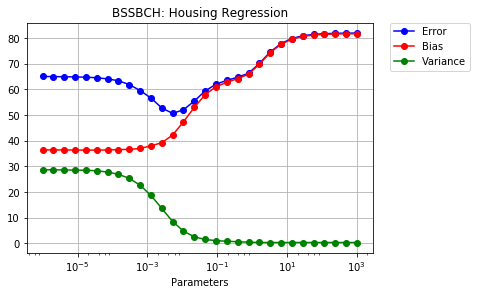

In [202]:
### TEST 1
%matplotlib inline
utils.plotBVE(utils.Housing,numpy.logspace(-6,3,num=30),utils.ParzenRegressor,utils.biasVarianceRegression,'BSSBCH: Housing Regression')

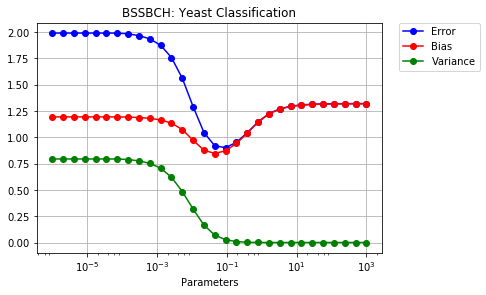

In [203]:
### TEST 2
%matplotlib inline
utils.plotBVE(utils.Yeast,numpy.logspace(-6,3,num=30),utils.ParzenClassifier,biasVarianceClassification,'BSSBCH: Yeast Classification')

## Part 2: Implementing a Parameter Selection Procedure (30 P)
In this part of the exercise, we would like to find what is the best hyperparameter of the model for predicting the Housing regression data. A 5-fold cross-validation procedure is already implemented and that allows to compute error bars.

![Loop](files/loop.png)

You need to extend this basic cross-validation procedure by a nested loop of 4-fold cross-validation that selects the best hyperparameters based on some criterion (cost function) to be determined. The nested loop is depicted below:

![Nested](files/nested.png)

The full procedure for evaluation and hyperparameter selection procedure is shown in the diagram below with the part that you need to implement highlighted in red.

![Procedure](files/procedure.png)

**Tasks:**


- **Implement the inner loop of 4-fold cross-validation, helping you from the diagram above (20 P)**

  For this part, use the following settings:

  - Range of parameters to test: 15 parameters logarithmically spaced between 1e-5 and 1e5.
  - The returned parameter is the geometric mean of the best parameter found for each split.
  - The best parameter for each split is the one that minimizes the `costfunction` specified as argument.
  - The bias and variance estimates are obtained by sampling 10 times from the training distribution.


- **Verify your implementation by running Test 3 (10 P)**

In [253]:
def getbestparameter( Xselect, Tselect, costfunction ):
    
    splits = [ ( [ 1, 2, 3 ], 0 ), ( [ 0, 2, 3 ], 1 ), ( [ 0, 1, 3 ], 2 ), ( [ 0, 1, 2 ], 3 ) ]
    parameters = numpy.logspace( -5, 5, 15 )
    bestP = []
    
    for train, validation in splits:
        
        Xtrain = [ Xselect[ i ] for i in train ]
        Xvalidation = Xselect[ validation ]
        Ttrain = [ Tselect[ i ] for i in train ]
        Tvalidation = Tselect[ validation ]
        
        lowerC = sys.maxint
        bestParam = 0
        
        for p in parameters:
            
            predictor = utils.ParzenRegressor( p )
            sampler = utils.Sampler( numpy.concatenate( Xtrain, 0 ), numpy.concatenate( Ttrain, 0 ) )
            bias, variance = utils.biasVarianceRegression( sampler, predictor, Xvalidation, Tvalidation )      
            
            cost = costfunction( bias, variance )
            if( cost < lowerC ):
                bestParam = p
                lowerC = cost
                
        bestP.append( bestParam )  
    return reduce(lambda x, y: x*y, bestP)**(1.0/len(bestP))  

In [254]:
def evaluateModel(X,T,costfunction): 
    # X: partitioned input
    # T: partitioned targets
    # costfunction: the function for evaluate how good/bad a hyperparameter is
    
    # Create splits
    splits = [ ([1,2,3,4],0) , ([0,2,3,4],1) , ([0,1,3,4],2) , ([0,1,2,4],3) , ([0,1,2,3],4) ]
    
    testbiases,testvariances,testerrors,bestparameters = [],[],[],[]

    #Loop over selection/test splits 
    for inds_select,ind_test in splits: 
         
        Xselect = [X[ind] for ind in inds_select]
        Tselect = [T[ind] for ind in inds_select]

        Xtest = X[ind_test]
        Ttest = T[ind_test]
        
        bestparam = getbestparameter(Xselect,Tselect,costfunction)
 
        # Evaluate bias and variance with this best parameter
        predictor = utils.ParzenRegressor(bestparam)
        sampler   = utils.Sampler(numpy.concatenate(Xselect,axis=0),numpy.concatenate(Tselect,axis=0))
        bias,variance = utils.biasVarianceRegression(sampler,predictor,Xtest,Ttest, nbsamples=20)
        
        testbiases     += [bias]
        testvariances  += [variance]
        testerrors     += [bias+variance]
        bestparameters += [bestparam]
 
    # Output results of model evaluation
    print('bias:      %8.5f +/- %8.5f'%(numpy.mean(testbiases),numpy.std(testbiases))) 
    print('variance:  %8.5f +/- %8.5f'%(numpy.mean(testvariances),numpy.std(testvariances))) 
    print('error:     %8.5f +/- %8.5f'%(numpy.mean(testerrors),numpy.std(testerrors)))
    print('parameter: %8.5f +/- %8.5f'%(numpy.mean(bestparameters),numpy.std(bestparameters)))

In [255]:
### TEST 3
costfunctions = [
         ('Parameter Selection Criterion: favor low bias', lambda b,v: 9*b+v),
         ('Parameter Selection Criterion: favor low error',lambda b,v: b+v),
         ('Parameter Selection Criterion: favor low variance',lambda b,v: b+9*v),
]

# Load and partition the data
X,T = utils.Housing()
n = len(X)
X = [X[n*i//5:n*(i+1)//5] for i in range(5)]
T = [T[n*i//5:n*(i+1)//5] for i in range(5)]

print "BSSBCH"
for name,costfunction in costfunctions:
    print('\n\n%s\n'%name)
    evaluateModel(X,T,costfunction)

BSSBCH


Parameter Selection Criterion: favor low bias

bias:      38.88084 +/-  6.24572
variance:  19.43528 +/-  2.95717
error:     58.31611 +/-  7.06686
parameter:  0.00019 +/-  0.00012


Parameter Selection Criterion: favor low error

bias:      46.12360 +/-  5.92860
variance:   4.30216 +/-  1.49455
error:     50.42575 +/-  6.35476
parameter:  0.00615 +/-  0.00268


Parameter Selection Criterion: favor low variance

bias:      64.30733 +/- 10.64762
variance:   0.48869 +/-  0.09947
error:     64.79602 +/- 10.58157
parameter:  0.19969 +/-  0.05227
